In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load cleaned dataset
df = pd.read_csv('superstore_cleaned.csv', parse_dates=['Order Date', 'Ship Date'])


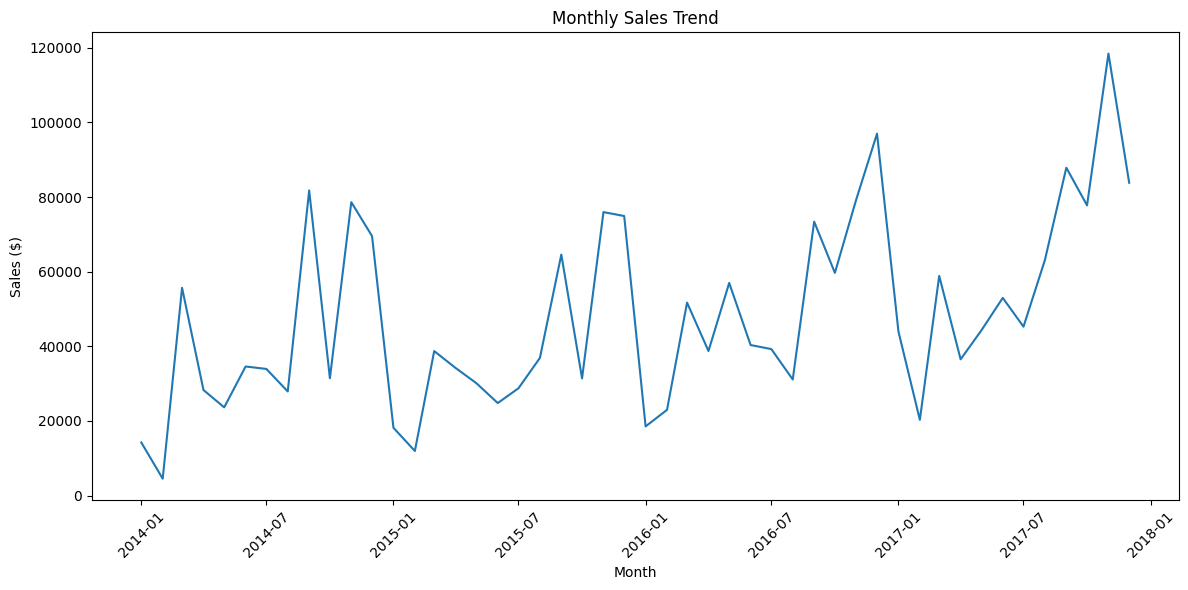

In [2]:
# Group by month
monthly_sales = df.groupby(df['Order Date'].dt.to_period('M')).sum(numeric_only=True)['Sales']
monthly_sales.index = monthly_sales.index.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


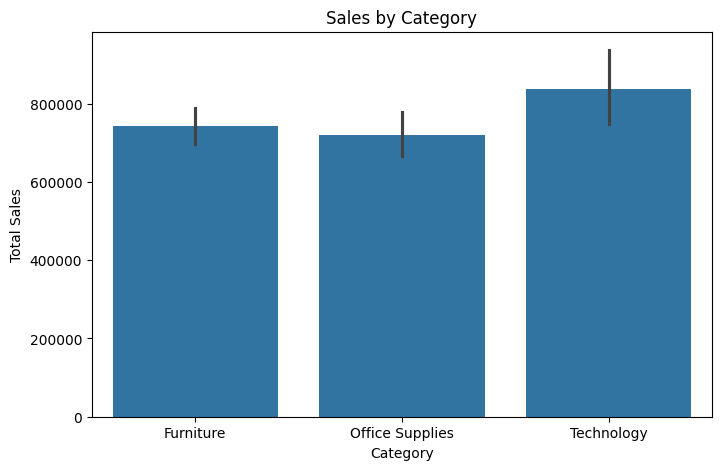

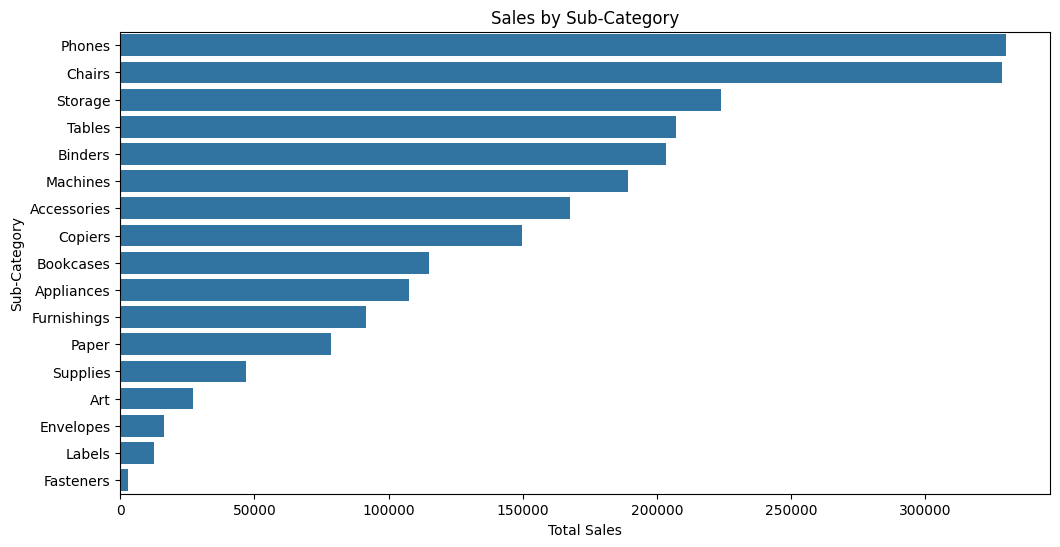

In [3]:
# Category Sales
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Category', y='Sales', estimator=sum)
plt.title('Sales by Category')
plt.ylabel('Total Sales')
plt.show()

# Sub-Category Sales
plt.figure(figsize=(12,6))
sub_sales = df.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False)
sns.barplot(x=sub_sales.values, y=sub_sales.index)
plt.title('Sales by Sub-Category')
plt.xlabel('Total Sales')
plt.show()


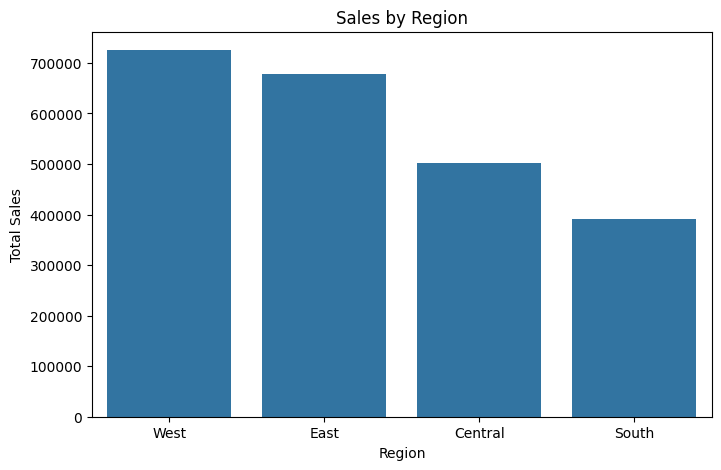

In [4]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.title('Sales by Region')
plt.ylabel('Total Sales')
plt.show()


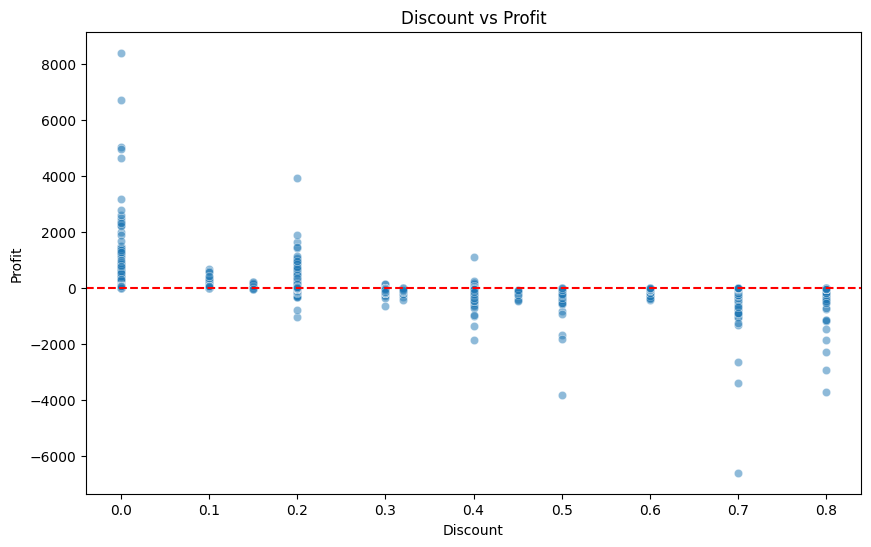

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Discount', y='Profit', alpha=0.5)
plt.title('Discount vs Profit')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [6]:
# Reference date = 1 day after last order
reference_date = df['Order Date'].max() + pd.Timedelta(days=1)

# Group by customer
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Customer ID': 'count',                                    # Frequency
    'Sales': 'sum'                                              # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Preview
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,185,11,5563.560
AA-10375,20,15,1056.390
AA-10480,260,12,1790.512
AA-10645,56,18,5086.935
AB-10015,416,6,886.156


In [7]:
# RFM scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine into RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
AA-10315,185,11,5563.560,2,3,5,235,10
AA-10375,20,15,1056.390,5,4,2,542,11
AA-10480,260,12,1790.512,1,3,3,133,7
AA-10645,56,18,5086.935,3,4,5,345,12
AB-10015,416,6,886.156,1,1,1,111,3


In [8]:
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal'
    elif score >= 7:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()


Segment
Loyal        248
Potential    218
At Risk      203
Champions    124
Name: count, dtype: int64

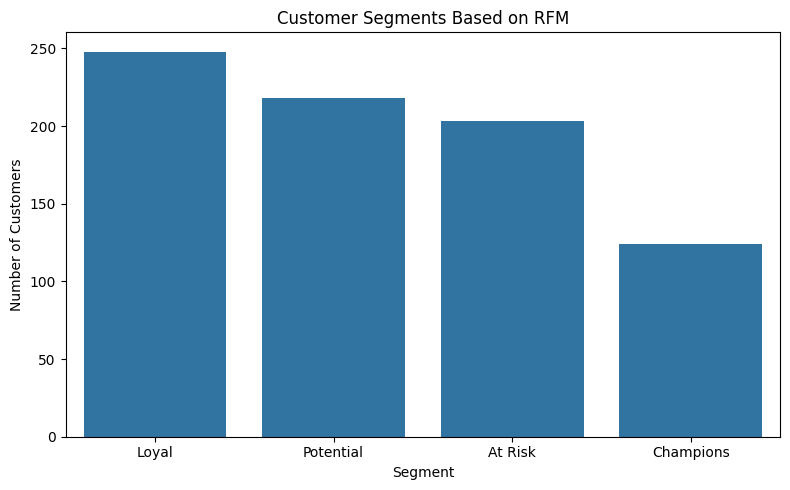

In [9]:
#visualize segments
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Based on RFM')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

In [10]:
#save RFM segments to CSV
rfm.to_csv('customer_rfm_segments.csv')


In [12]:
#save plot figures
plt.savefig('monthly_sales.png', dpi=300)


<Figure size 640x480 with 0 Axes>